## 4. Model Evaluation
confusion matrix, hyperparameter optimization (random forests), cross validation, train_test_split (should have been done before?), metrices, accuracy, precision, recall

 In machine learning, model validation is referred to as the process where a trained model is
 evaluated with a testing data set. The testing data set is a separate portion of the same data
 set from which the training set is derived. The main purpose of using the testing data set is to
 test the generalization ability of a trained model ([Alpaydin 2010](http://scholar.google.com/scholar_lookup?title=Introduction%20to%20machine%20learning&author=E.%20Alpaydin&publication_year=2010)).
 
 The outline of the model building and evaluation process is given below.
 <img src="../img/4/model_evaluation_process.PNG" width=400>

In [25]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, TimeSeriesSplit
from sklearn.metrics import average_precision_score, accuracy_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline

# data are stored here
data_folder = '../datasets'

# integer for the random seed
THE_ANSWER = 42

In [2]:
# load data
data = np.load('%s/data.npz' % data_folder)

# extract training data
X_train, y_train = data['X_train'], data['y_train']

In [18]:
# let's take a look at the class labels stored in the y_train array
print(y_train)

# only 34% of objects are of class 1 --> the data set is imbalanced
print('The class == 1 objects make %0.f%% of the training set.' % (100*y_train.sum()/y_train.size))

[0. 1. 1. ... 0. 0. 0.]
The class == 1 objects make 34% of the training set.


In [4]:
# instantiate the RandomForestClassifier
model = RandomForestClassifier()

# print out the default values of model hyper-parameters (will talk about hyper-parameters later)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [5]:
# set the number of trees to 500, and the random seed to THE_ANSWER for reproducibility
model.set_params(n_estimators=500, random_state=THE_ANSWER)
#model = RandomForestClassifier(n_estimators=500, random_state=THE_ANSWER) # another way of doing it

# check that the model changed
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [6]:
# some values in the training set are NaN (i.e., are missing).
# The Random Forest classifier does not like that, so we set NaN values to 10000.
X_train_fixed = X_train.copy()
X_train_fixed[np.isnan(X_train_fixed)] = 10000

In [7]:
# fit the model using training data
model.fit(X_train_fixed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Classification metrics

### Accuracy

Now that we have fit a model, we need to evaluate its performance.
That can be done using various [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics), but the simplest one is accuracy.
Accuracy is defined as the percentage of correct predictions for the test data.

$$accuracy = \frac{{\rm number\, of\, correct\, predictions}}{{\rm number\, of\, all\, predictions}}$$

In [19]:
# first, extract test data
X_test, y_test = data['X_test'], data['y_test']

# if there are NaNs in the test set, set them to 10000.
X_test_fixed = X_test.copy()
X_test_fixed[np.isnan(X_test)] = 10000

# only 34% of objects are of class 1 --> the data set is imbalanced
print('The class == 1 objects make %0.f%% of the test set.' % (100*y_test.sum()/y_test.size))

# now push the test set through the model to get the predicted classes
y_pred = model.predict(X_test_fixed)

print('Predicted class:', y_pred)
print('True class:     ', y_test)

The class == 1 objects make 35% of the test set.
Predicted class: [0. 0. 0. ... 1. 0. 0.]
True class:      [1. 0. 0. ... 1. 0. 1.]


In [10]:
# calculate the accuracy
print('The accuracy is %.3f.' % accuracy_score(y_test, y_pred))

The accuracy is 0.892.


That's a great result, right? Maybe not since we have an imbalanced data set (i.e., class == 1 objects make only 35% of the test set). Here's an extreme example how accuracy can be misleading when the classes are imbalanced:

Imagine a data set where 90% of objects are of class 0. A naive classifier that predicts 0 for all objects will have an accuracy of 90%!

### Precision and Recall

In my opinion, what most business people would like to know is the following:
1. What is the detection rate? Did we correctly identify 50%, 80%, or more of all class 1 objects (e.g., instructions that will fail to settle)?
2. What is the false alarm rate? What percentage of those tagged as class 1 are **not** of class 1?

The detection rate is called "recall" in machine learning, and the false alarm rate is related to "precision" (actually, it is 1-precision).

In [ ]:
# GENIA: use graphics on this page to explain the confusion matrix, precision, and recall
# https://www.jeremyjordan.me/evaluating-a-machine-learning-model/

Now that we understand the confusion matrix, precision, and recall, let's calculate them using the test set for the model we just trained.

In [20]:
p = precision_score(y_test, y_pred)
r = recall_score(y_test, y_pred)
print('The precision obtained on the test set is %.0f%% and recall is %.0f%%.' % (p*100, r*100))

The precision obtained on the test set is 86% and recall is 83%.


The above precision and recall indicate that our model is able to detect 83% of all class == 1 objects (i.e., failed settlements), while having a false alarm rate of only 14% (remember that the false alarm rate = 1 - precision).

But what if a detection rate of 86% is not good enough for your use case? What if you willing to accept a higher false alarm rate if that would enable you to identify more of class == 1 objects (i.e., have a higher detection rate)?

This can be achieved by:
1. Calculating classification **scores** (values 0 to 1) instead of predicting class **labels** (values 0 or 1),
2. Plotting the precision-recall curve, and
3. Selecting all objects that have the classification score higher than some threshold.

Let's start by calculating and explaining classification scores.

In [22]:
# push the test data set through the model to get the classification *scores* (not labels)
# (note that we use the "predict_proba" method and not "predict")
y_scores = model.predict_proba(X_test_fixed)

# the model calculates the score for both classes (0 and 1). Each row sums to 1.
print(y_scores)
print('The y_scores is a 2-dimensional array:', y_scores.shape)

[[0.88866667 0.11133333]
 [0.828      0.172     ]
 [0.85693333 0.14306667]
 ...
 [0.378      0.622     ]
 [0.584      0.416     ]
 [0.804      0.196     ]]
The y_scores is a 2-dimensional array: (22034, 2)


Now that we have classification scores, let's plot the (1-precision) vs. recall curve.

Score > 0.557:  78% detection rate at 10% false alarm rate.
Score > 0.487:  84% detection rate at 15% false alarm rate.
Score > 0.451:  87% detection rate at 20% false alarm rate.
Score > 0.000: 100% detection rate at 65% false alarm rate (naive approach).


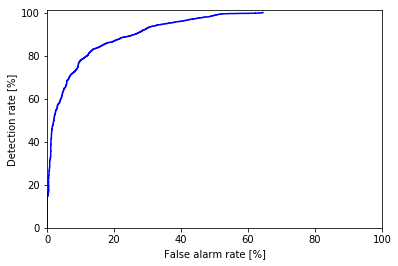

In [38]:
# plot the detection rate vs. false alarm rate
p, r, thresh = precision_recall_curve(y_test, y_scores[:, 1])
thresh = np.append(0, thresh)
print('Score > %.3f:  %.0f%% detection rate at 10%% false alarm rate.' % (thresh[(1-p) > 0.1][-1], 100*r[(1-p) > 0.1][-1]))
print('Score > %.3f:  %.0f%% detection rate at 15%% false alarm rate.' % (thresh[(1-p) > 0.15][-1], 100*r[(1-p) > 0.15][-1]))
print('Score > %.3f:  %.0f%% detection rate at 20%% false alarm rate.' % (thresh[(1-p) > 0.2][-1], 100*r[(1-p) > 0.2][-1]))
print('Score > 0.000: 100%% detection rate at %.0f%% false alarm rate (naive approach).' % (100-100*y_test.sum()/y_test.size))

fig, ax = plt.subplots()
ax.step((1-p)*100, r*100, color='b', where='post', label='late settlements')
ax.set_xlabel('False alarm rate [%]')
ax.set_ylabel('Detection rate [%]')
ax.set_ylim([0.0, 101])
_ = ax.set_xlim([0.0, 100])

Thus, if we select all objects (rows) that have the classification score (y_scores[:, 1]) greater than 0.557, we can expect a sample where 78% of objects will be of class 1 (e.g., will be failed settlements), and only 10% will be of class 0.

Example: Let's say there are 100 objects (rows) that have the classification score greater than 0.577. This mean that 90 objects will truly be of class 1 (false alarm rate is 10% --> precision is 90% --> 100*0.9 = 90). The total number of class 1 objects is 115 ( = 90/0.78 --> because detection rate is 78%), which means the algorithm misses 25 objects (rows) of class 1.

The area under the precision-recall curve (AUPRC) is also a metric. The ideal classifier (model) has a detection rate of 100% and false alarm rate of 0%, and the AUPRC = 1.

In [41]:
# calculate the area under the precision-recall curve for class == 1 objects
# by feeding the true class label (y_test) and the predicted classification scores (y_scores[:, 1])
print('The area under the precision-recall curve is %.3f.' % average_precision_score(y_test, y_scores[:, 1]))

The area under the precision-recall curve is 0.923.


### Log loss or cross-entropy

The metric of choice for evaluating multi-class classification models. For more details, see [here](http://wiki.fast.ai/index.php/Log_Loss).

## Regression metrics

** (Root) Mean Squared Error** is simply defined as the (root of the) average of squared differences between the predicted output and the true output.

In [ ]:
# different metrics for evaluating classification models can be found here:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [ ]:
X_valid, y_valid = data['X_valid'], data['y_valid']
X_devel, y_devel = data['X_devel'], data['y_devel']
X_test, y_test = data['X_test'], data['y_test']